In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime
import torchvision.models as models
import random
import numpy as np


In [2]:
# 画像のサイズ
IMG_SIZE = 224

# データのディレクトリのパス
TRAIN_DIR = '../input/seg_train/'
TEST_DIR = '../input/seg_test/'

batch_size = 128

model_name = "ResNet18"

In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_dataset = datasets.ImageFolder(TEST_DIR, transform=val_transforms)

In [5]:
# Data Loader
train_loader = DataLoader(train_dataset, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size, num_workers=2)


In [6]:
# ResNet-18モデルの定義
class CustomResNet18(nn.Module):
    def __init__(self, num_classes):
        super(CustomResNet18, self).__init__()
        self.resnet = models.resnet18(weights="IMAGENET1K_V1")  # 事前学習済みのResNet-18モデルをロード
        # 最終の全結合層を入れ替えて、出力クラスの数に合わせる
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)

    def forward(self, x):
        return self.resnet(x)


In [7]:
# 2. モデルの構築
model = CustomResNet18(num_classes=6).to(device)


In [8]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)



In [9]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, total=len(train_loader), desc=f"Epoch {epoch+1}/{num_epochs}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [10]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/50, Train Loss: 0.37922524927406137, Val Loss: 0.5669788497810563, Train Acc: 0.8626193529998575, Val Acc: 0.8086666666666666


Epoch 2/50, Train Loss: 0.25848863827526025, Val Loss: 0.3582078469917178, Train Acc: 0.9062277326492804, Val Acc: 0.876


Epoch 3/50, Train Loss: 0.23205176255571733, Val Loss: 0.3726154909042331, Train Acc: 0.9107880860766709, Val Acc: 0.873


Epoch 4/50, Train Loss: 0.20621949700860803, Val Loss: 0.840540178808927, Train Acc: 0.9221889696451475, Val Acc: 0.7466666666666667


Epoch 5/50, Train Loss: 0.19180361044789673, Val Loss: 0.2928035388079782, Train Acc: 0.9269630896394471, Val Acc: 0.8993333333333333


Epoch 6/50, Train Loss: 0.17401170573376734, Val Loss: 0.4835144410220285, Train Acc: 0.9343024084366538, Val Acc: 0.8446666666666667


Epoch 7/50, Train Loss: 0.17437841251082375, Val Loss: 0.315158264633889, Train Acc: 0.9324497648567764, Val Acc: 0.8916666666666667


Epoch 8/50, Train Loss: 0.15538972506829357, Val Loss: 0.356486465393876, Train Acc: 0.9394328060424683, Val Acc: 0.888


Epoch 9/50, Train Loss: 0.15104741767185545, Val Loss: 0.319614666281268, Train Acc: 0.9398603391762862, Val Acc: 0.8946666666666667


Epoch 10/50, Train Loss: 0.1385950826860349, Val Loss: 0.29089097841642797, Train Acc: 0.9447057146928887, Val Acc: 0.903


Epoch 11/50, Train Loss: 0.1164549858813439, Val Loss: 0.35029783053323627, Train Acc: 0.9515462448339747, Val Acc: 0.8953333333333333


Epoch 12/50, Train Loss: 0.11797671556609486, Val Loss: 0.4069160756965478, Train Acc: 0.9507624340886419, Val Acc: 0.8803333333333333


Epoch 13/50, Train Loss: 0.11351370973803035, Val Loss: 0.31504901265725493, Train Acc: 0.9533988884138521, Val Acc: 0.8943333333333333


Epoch 14/50, Train Loss: 0.10159795358777046, Val Loss: 0.3326250385725871, Train Acc: 0.95717543109591, Val Acc: 0.8933333333333333


Epoch 15/50, Train Loss: 0.08583531094663734, Val Loss: 0.32751465891487896, Train Acc: 0.9628758728801482, Val Acc: 0.9103333333333333


Epoch 16/50, Train Loss: 0.0831640267556687, Val Loss: 0.42263352560500306, Train Acc: 0.9647997719823286, Val Acc: 0.8826666666666667


Epoch 17/50, Train Loss: 0.09243009271903323, Val Loss: 0.37492248276248574, Train Acc: 0.9613795069117856, Val Acc: 0.8933333333333333


Epoch 18/50, Train Loss: 0.0746823158969573, Val Loss: 0.3423736001488275, Train Acc: 0.9669374376514179, Val Acc: 0.902


Epoch 19/50, Train Loss: 0.06748607669264899, Val Loss: 0.2889217758978096, Train Acc: 0.9706427248111729, Val Acc: 0.917


Epoch 20/50, Train Loss: 0.056741006950070276, Val Loss: 0.31153473931287107, Train Acc: 0.9753455892831695, Val Acc: 0.917


Epoch 21/50, Train Loss: 0.05397314636395612, Val Loss: 0.339569551909032, Train Acc: 0.9741342454040188, Val Acc: 0.9143333333333333


Epoch 22/50, Train Loss: 0.05334410372984792, Val Loss: 0.39912332221865654, Train Acc: 0.973635456747898, Val Acc: 0.9066666666666666


Epoch 23/50, Train Loss: 0.06488107113218909, Val Loss: 0.3947340026461461, Train Acc: 0.9714265355565056, Val Acc: 0.904


Epoch 24/50, Train Loss: 0.05660207485865562, Val Loss: 0.4438900897124161, Train Acc: 0.9743480119709278, Val Acc: 0.9


Epoch 25/50, Train Loss: 0.04372612558253998, Val Loss: 0.43269514637844014, Train Acc: 0.9783383212198945, Val Acc: 0.9053333333333333


Epoch 26/50, Train Loss: 0.056383062290762544, Val Loss: 0.37135712592862546, Train Acc: 0.9744192674932307, Val Acc: 0.907


Epoch 27/50, Train Loss: 0.04886155654120883, Val Loss: 0.38199197066326934, Train Acc: 0.9774832549522589, Val Acc: 0.915


Epoch 28/50, Train Loss: 0.03480162716752619, Val Loss: 0.40547719101111096, Train Acc: 0.9828274191249822, Val Acc: 0.908


Epoch 29/50, Train Loss: 0.04551491568104253, Val Loss: 0.36704412981513695, Train Acc: 0.9789796209206213, Val Acc: 0.9143333333333333


Epoch 30/50, Train Loss: 0.03962613642642941, Val Loss: 0.40549033423303626, Train Acc: 0.9807610089781958, Val Acc: 0.906


Epoch 31/50, Train Loss: 0.04078257892391892, Val Loss: 0.5014872888568789, Train Acc: 0.9795496650990452, Val Acc: 0.8956666666666667


Epoch 32/50, Train Loss: 0.04202320492920389, Val Loss: 0.40721225754896295, Train Acc: 0.9799059427105601, Val Acc: 0.9126666666666666


Epoch 33/50, Train Loss: 0.02628897479948921, Val Loss: 0.5607824431111416, Train Acc: 0.9848938292717686, Val Acc: 0.89


Epoch 34/50, Train Loss: 0.038190277028452915, Val Loss: 0.384734392282553, Train Acc: 0.9811885421120137, Val Acc: 0.9103333333333333


Epoch 35/50, Train Loss: 0.03624984709580147, Val Loss: 0.4377478001018365, Train Acc: 0.9809747755451047, Val Acc: 0.9006666666666666


Epoch 36/50, Train Loss: 0.03797099155100456, Val Loss: 0.47117273102048784, Train Acc: 0.9821861194242554, Val Acc: 0.905


Epoch 37/50, Train Loss: 0.0370298443755152, Val Loss: 0.3959536198720646, Train Acc: 0.9811885421120137, Val Acc: 0.9126666666666666


Epoch 38/50, Train Loss: 0.030557287028144805, Val Loss: 0.39754972808683914, Train Acc: 0.9841812740487388, Val Acc: 0.914


Epoch 39/50, Train Loss: 0.028101535513997078, Val Loss: 0.401505299222966, Train Acc: 0.9846800627048596, Val Acc: 0.913


Epoch 40/50, Train Loss: 0.028901090542145007, Val Loss: 0.47878461657091975, Train Acc: 0.9838249964372239, Val Acc: 0.9053333333333333


Epoch 41/50, Train Loss: 0.03788121926615339, Val Loss: 0.4410927021720757, Train Acc: 0.9809035200228018, Val Acc: 0.908


Epoch 42/50, Train Loss: 0.031168365851044655, Val Loss: 0.4629890799211959, Train Acc: 0.983468718825709, Val Acc: 0.909


Epoch 43/50, Train Loss: 0.024214381422557003, Val Loss: 0.4852200975874439, Train Acc: 0.9855351289724954, Val Acc: 0.9123333333333333


Epoch 44/50, Train Loss: 0.028846800143599784, Val Loss: 0.5332357813992227, Train Acc: 0.9847513182271626, Val Acc: 0.8966666666666666


Epoch 45/50, Train Loss: 0.020781517614089293, Val Loss: 0.4552958446535437, Train Acc: 0.9872452615077668, Val Acc: 0.914


Epoch 46/50, Train Loss: 0.017594018005851416, Val Loss: 0.44443112541921437, Train Acc: 0.9878153056861907, Val Acc: 0.9143333333333333


Epoch 47/50, Train Loss: 0.029818496256724957, Val Loss: 0.4618483918408553, Train Acc: 0.9848938292717686, Val Acc: 0.9126666666666666


Epoch 48/50, Train Loss: 0.030405189405161237, Val Loss: 0.45863204224345583, Train Acc: 0.9840387630041328, Val Acc: 0.9096666666666666


Epoch 49/50, Train Loss: 0.03307723098887353, Val Loss: 0.41655547115563724, Train Acc: 0.983112441214194, Val Acc: 0.9173333333333333


Epoch 50/50, Train Loss: 0.025333713932355884, Val Loss: 0.43545895302668214, Train Acc: 0.9848225737494656, Val Acc: 0.9123333333333333


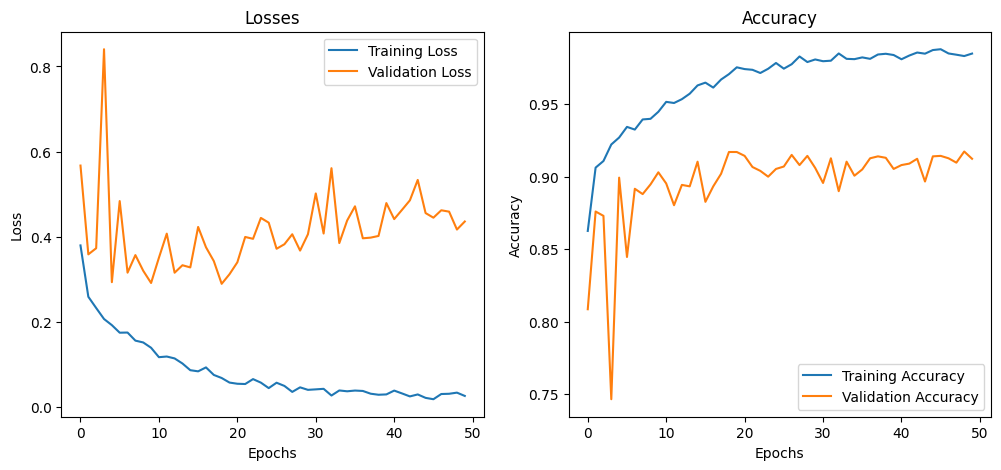

In [11]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')


# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'{model_name}_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'{model_name}_{timestamp}.png'))

# 画像を表示
plt.show()
